In [19]:
import numpy as np
import time
from scipy.sparse import csr_matrix
from scipy.linalg import qr
import collections
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt 

# Algorithm

In [5]:
# input:
# A is a numpy matrix mxn
# P_c is a permutation matrix as an int ndarray of shape (N,)
# k is an integer
# output:
# Q_k is a numpy matrix
# R_k is a numpy matrix
def lu_crtp_4(A, P_c, k):
    AP_c = A[:, P_c]
    AP_c_selected_columns = AP_c[:, :k]
    Q_k, R_k = np.linalg.qr(AP_c_selected_columns)
    return Q_k, R_k

# input:
# a is a numpy matrix mxn
# k is an even integer
def lu_crtp(a, k, debug=False):
    if(k > min(a.shape)):
        raise Exception("k cannot be less than any dimension of the input matrix!")
    
    # According to https://epubs-siam-org.uaccess.univie.ac.at/doi/epdf/10.1137/13092157X QR_TP is the same
    # as RRQR. For a faster implementation, we therefore decided on using scipy's LAPACK interface.
    # Select k columns by using QR with tournament pivoting on A
    _, _, p_c = qr(a, pivoting=True)
    #p_c = p_c[:k]


    # Compute the thin QR factorization of the selected columns
    q_k, r_k = lu_crtp_4(a, p_c, k)
    if(debug):
        print("q_k:")
        print(q_k.shape)
        print("r_k:")
        print(r_k.shape)


    # Select k rows by using QR with tournament pivoting on Q^T_k
    _, _, p_r = qr(q_k.T, pivoting=True)
    #p_r = p_r[:k]

    # Let A_ = P ...
    a_dash = a[p_r,:]
    a_dash = a_dash[:,p_c]
    rows, cols = a_dash.shape
    if(debug):
        print("a_dash:")
        print(a_dash.shape)
    
    # Separate into block matrices
    a_dash_11 = a_dash[:k, :k]
    a_dash_21 = a_dash[k:, :k]
    a_dash_12 = a_dash[:k, k:]
    if(debug):
        print("a_dash_11:")
        print(a_dash_11.shape)
        print("a_dash_21:")
        print(a_dash_21.shape)
        print("a_dash_12:")
        print(a_dash_12.shape)


    # Compute L_21
    inv_a_dash_11 = np.linalg.inv(a_dash_11)
    l_21 = np.dot(a_dash_21, inv_a_dash_11)
    if(debug):
        print("l_21:")
        print(l_21.shape)

    
    # Stack the block matrices
    i = np.identity(k)
    l_k = np.vstack((i, l_21))
    if(debug):
        print("l_k:")
        print(l_k.shape)
    u_k = np.hstack((a_dash_11, a_dash_12))
    if(debug):
        print("u_k:")
        print(u_k.shape)
    return p_r, p_c, l_k, u_k, r_k

# returns true if A and the approximation is equal
def compareApprox(A, p_r, p_c, l_k, u_k):
    approx = np.dot(l_k, u_k)
    print("approx:")
    print(approx)
    PA = p_A = A[p_r, :]
    PA = p_A[:, p_c]
    print("PA:")
    print(PA)
    return np.allclose(approx, PA)

In [6]:
def svg(A, k):
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    S = S[:k]
    return np.matmul(U[:, :k] * S[..., None, :], Vh[:k, :])

In [7]:
def nmf(A, k):
    estimator = NMF(n_components = k, init = None, tol=1e-2, max_iter=100, random_state=1234)
    W = estimator.fit_transform(A)
    H = estimator.components_
    return np.dot(W,H)

# Recommender System

In [8]:
def my_apriori(mapped_records, min_support, debug=False):
    l1_items = collections.Counter()
    total_items_per_record = 0
    for record in mapped_records:
        l1_items.update(record)
        total_items_per_record = total_items_per_record + len(record)
        
    items_per_record = total_items_per_record / len(mapped_records)
    if(debug):
        print(f"{items_per_record=}")
        
    frequent_l1_items = {}
    min_support = min_support * len(mapped_records)
    if(debug):
        print(f"{min_support=}")
        
    for item in l1_items:
        support = l1_items[item]
        if support >= min_support:
            frequent_l1_items[(item,)] = support
    frequent_itemsets = {}
    for item in frequent_l1_items:
        frequent_itemsets[item] = frequent_l1_items[item]
    frequent_n_itemsets = frequent_l1_items
    
    if(debug):
        print(f"{len(mapped_records)=}")
        
    def apriori_gen(itemsets):
        if(debug):
            print(f"{len(itemsets)=}")
        C_k = set()
        for p in itemsets:
            for q in itemsets:
                if p[-1] < q[-1]:
                    C_k.add( p + (q[-1],) )
        def all_subsets_in_itemsets(x):
            for subset in itertools.combinations(x, len(x) - 1):
                if subset not in itemsets:
                    return False
            return True
        if(debug):
            print(f"{len(C_k)=}")
        result = list(filter(all_subsets_in_itemsets, C_k))
        if(debug):
            print(f"{len(result)=}")
        return result

    def calculate_support(itemset):
        support = 0
        for record in mapped_records:
            itemset_in_record = all(item in record for item in itemset)
            if itemset_in_record:
                support += 1
        return support

    while len(frequent_n_itemsets) != 0:
        if(debug):
            print(f"{len(frequent_n_itemsets)=}")        
        candidates = apriori_gen(frequent_n_itemsets)
        if(debug):
            print(f"{len(candidates)=}")        
        supports = [calculate_support(candidate) for candidate in candidates]
        frequent_candidates = {
                    candidate: support for candidate, support in zip(candidates, supports) if support >= min_support
                }
        for item in frequent_candidates:
            frequent_itemsets[item] = frequent_candidates[item]
        frequent_n_itemsets = [itemset for itemset in frequent_candidates]

    return frequent_itemsets

In [9]:
def Recommender_System(orders, max_columns_for_apriori=100, item_threshold=0.5, debug=False):   
    mapped_records = []
    # In the following tasks use the mapped records to compute the frequent itemsets.
    for record in orders:
        mask = record >= item_threshold
        indices = np.where(mask)[0]
        #indices = np.sort(indices)
        #mapped_records.append(indices.tolist())
        if len(indices) > 0:
            mapped_records.append(indices.tolist())
            
    sortedColumnSums = np.sort(np.where(orders >= item_threshold, 1, 0).sum(axis=0))
    if debug:
        print("sortedColumnSums:")
        print(sortedColumnSums)
    minSupport = 0
    if max_columns_for_apriori < len(sortedColumnSums):
        minSupport = sortedColumnSums[-max_columns_for_apriori] + 1
    else:
        minSupport = sortedColumnSums[0]
    if debug:
        print("minSupport:")
        print(minSupport)
    if minSupport < 1:
        minSupport = 1
    minSupport = minSupport / len(mapped_records)
    
    if debug:
        print(f"starting apriori with min_support: {minSupport}")
    return my_apriori(mapped_records, min_support=minSupport, debug=debug)
    #return other_apriori(mapped_records, min_support=minSupport)

def print_support(supports):
    for itemset in supports:
        support = supports[itemset]
        print(f"{itemset} : {support}")
        
def compare_supports(supports1, supports2):
    dist = 0
    for itemset in supports1:
        support1 = supports1[itemset]
        support2 = supports2.get(itemset, 0)
        dist = dist + np.square(support1 - support2)
    for itemset in supports2:
        support2 = supports2[itemset]
        if(itemset not in supports1):
            dist = dist + np.square(support2)            
    return np.sqrt(dist)

# Generate Matrices

In [10]:
def read_file_as_sparse_matrix(filename, row_column, column_column, data_column, separator=',', max_lines=1000, mode='int'):   
    row = []
    row_max = 0
    col = []
    col_max = 0
    data = []
    row_to_original = []
    col_to_original = []
    original_to_row = {}
    original_to_col = {}
    with open(filename, 'r') as file:
        line_counter = 0
        for line in file:
            split_line = line.split(separator)
            
            row_original = split_line[row_column].strip()
            if row_original not in original_to_row:
                row_to_original.append(row_original)
                original_to_row[row_original] = len(row_to_original) - 1
            row_entry = original_to_row[row_original]
            if row_entry > row_max:
                row_max = row_entry
            row.append(row_entry)
            
            col_original = split_line[column_column].strip()
            if col_original not in original_to_col:
                col_to_original.append(col_original)
                original_to_col[col_original] = len(col_to_original) - 1
            col_entry = original_to_col[col_original]
            if col_entry > col_max:
                col_max = col_entry
            col.append(col_entry)
            
            if mode == 'int':
                data_entry = int(split_line[data_column])
                data.append(data_entry)
            elif mode == 'float':
                data_entry = float(split_line[data_column])
                data.append(data_entry)
            else:
                raise Exception("mode value not recognized!")

            line_counter = line_counter + 1
            if line_counter >= max_lines:
                break
    
    m = len(row)
    if len(col) != m or len(data) != m:
        raise Exception("row, col and data need the same amount of values!")
    
    sparseMatrix = csr_matrix((data, (row, col)), shape = (row_max + 1, col_max + 1))
    return sparseMatrix.toarray(), row_to_original, col_to_original, original_to_row, original_to_col

def generate_random_matrix(shape, density, rng):
    return rng.choice([0, 1], size=shape, p=[1 - density, density])

# Testing

In [11]:
def test(original, max_columns_for_apriori, item_threshold, k_max=-1):
    stats_dict = {}
    time_dict = {}
    result_dict = {}

    k=16
    if k_max < k:
        k_max = min(original.shape)
    while True:
        print(f"\n{k=}:")
        loop_start_time = time.time()

        #original stats
        above_threshold_og = np.count_nonzero(np.where(original >= item_threshold, 1, 0))
        density_og = above_threshold_og / np.prod(original.shape)
        
        #use the algorithm
        start_time = time.time()
        p_r, p_c, l_k, u_k, r_k = lu_crtp(original, k, debug=False)
        approx = np.dot(l_k, u_k)
        algorithm_time = time.time() - start_time

        #pivot original matrix
        pivoted_original = p_A = original[p_r, :]
        pivoted_original = p_A[:, p_c]
        
        #approximated stats
        mse_ap = mean_squared_error(pivoted_original, approx)
        above_threshold_ap = np.count_nonzero(np.where(approx >= item_threshold, 1, 0))
        density_ap = above_threshold_ap / np.prod(approx.shape)
        
        #Recommender Systems
        start_time = time.time()
        support_og = Recommender_System(pivoted_original, max_columns_for_apriori, item_threshold=item_threshold)
        original_rec_time = time.time() - start_time
        start_time = time.time()
        support_ap = Recommender_System(approx, max_columns_for_apriori, item_threshold=item_threshold)    
        approx_rec_time = time.time() - start_time
        dist_ap = compare_supports(support_og, support_ap)

        support_og2 = Recommender_System(original, max_columns_for_apriori, item_threshold=item_threshold)
        
        #svg
        start_time = time.time()
        approx_svg = svg(original, k)
        svg_time = time.time() - start_time
        mse_svg = mean_squared_error(original, approx_svg)
        above_threshold_svg = np.count_nonzero(np.where(approx_svg >= item_threshold, 1, 0))
        density_svg = above_threshold_svg / np.prod(approx_svg.shape)
        start_time = time.time()
        support_svg = Recommender_System(approx_svg, max_columns_for_apriori, item_threshold=item_threshold)    
        svg_rec_time = time.time() - start_time
        dist_svg = compare_supports(support_og2, support_svg)
        
        #nmf
        start_time = time.time()
        approx_nmf = nmf(original, k)
        nmf_time = time.time() - start_time
        mse_nmf = mean_squared_error(original, approx_nmf)
        above_threshold_nmf = np.count_nonzero(np.where(approx_nmf >= item_threshold, 1, 0))
        density_nmf = above_threshold_nmf / np.prod(approx_nmf.shape)
        start_time = time.time()
        support_nmf = Recommender_System(approx_nmf, max_columns_for_apriori, item_threshold=item_threshold)    
        nmf_rec_time = time.time() - start_time
        dist_nmf = compare_supports(support_og2, support_nmf)

        stats_dict[k] = (0, above_threshold_og, density_og, mse_ap, above_threshold_ap, density_ap, mse_svg, above_threshold_svg, density_svg, mse_nmf, above_threshold_nmf, density_nmf)
        result_dict[k] = (dist_ap, dist_svg, dist_nmf, len(support_og), len(support_ap), len(support_svg), len(support_nmf))
        time_dict[k] = (algorithm_time, svg_time, nmf_time, original_rec_time, approx_rec_time, svg_rec_time, nmf_rec_time)
        
        print(f"{k=} finished in {np.round(time.time() - loop_start_time, 5)} seconds")
        if k == k_max:
            break
        k = k * 2
        if k > k_max:
            k = k_max
    return stats_dict, result_dict, time_dict
    

In [12]:
def checkS(A):
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    nnz = np.count_nonzero(np.where(S > 0.01, 1, 0))
    print(f"{nnz} of {len(S)}")
    return nnz

def test_wrapper(matrix, name):
    max_columns_for_apriori = 30
    matrix_min = np.min(matrix)
    matrix_max = np.max(matrix)
    item_threshold= (matrix_max - matrix_min) / 2 # 2.5
    density = np.count_nonzero(matrix) / np.prod(matrix.shape)
    k_max = checkS(matrix)
    print(f"{max_columns_for_apriori=}")
    print(f"{matrix.shape=}")
    print(f"{matrix_min=}")
    print(f"{matrix_max=}")
    print(f"{item_threshold=}")
    print(f"{density=}")
    print(f"{k_max=}")

    with open(f"output/{name}.info", "w+") as infofile:
        infofile.write(f"{max_columns_for_apriori=}\n")
        infofile.write(f"{matrix.shape=}\n")
        infofile.write(f"{matrix_min=}\n")
        infofile.write(f"{matrix_max=}\n")
        infofile.write(f"{item_threshold=}\n")
        infofile.write(f"{density=}\n")
        infofile.write(f"{k_max=}\n")
    stats_dict, result_dict, time_dict = test(matrix, max_columns_for_apriori, item_threshold=item_threshold, k_max=k_max)
        
    with open(f"output/{name}.dat", "w+") as file:
        for k in stats_dict:
            stats_output = " ".join(map(str, stats_dict[k]))
            result_output = " ".join(map(str, result_dict[k]))
            time_output = " ".join(map(str, time_dict[k]))
            file.write(f"{k} {stats_output} {result_output} {time_output}\n")
    return stats_dict, result_dict, time_dict

In [11]:
shapes = [(400, 200), (800, 400), (1000, 1000)]
for shape in shapes:
    rng = np.random.default_rng(1234)
    density = 0.001
    rng_matrix = generate_random_matrix(shape, density, rng)
    test_wrapper(rng_matrix, f"rng-{shape[0]}-{shape[1]}-001")
    
#shapes = [(400, 200), (800, 400), (1000, 1000)]
for shape in shapes:
    rng = np.random.default_rng(1234)
    density = 0.01
    rng_matrix = generate_random_matrix(shape, density, rng)
    test_wrapper(rng_matrix, f"rng-{shape[0]}-{shape[1]}-01")

69 of 200
max_columns_for_apriori=30
matrix.shape=(400, 200)
matrix_min=0
matrix_max=1
item_threshold=0.5
density=0.0011375
k_max=69

k=16:
k=16 finished in 0.11803 seconds

k=32:
k=32 finished in 0.28063 seconds

k=64:
k=64 finished in 0.21064 seconds

k=69:
k=69 finished in 0.33387 seconds
210 of 400
max_columns_for_apriori=30
matrix.shape=(800, 400)
matrix_min=0
matrix_max=1
item_threshold=0.5
density=0.001071875
k_max=210

k=16:
k=16 finished in 0.87548 seconds

k=32:
k=32 finished in 1.05626 seconds

k=64:
k=64 finished in 1.11925 seconds

k=128:
k=128 finished in 2.63445 seconds

k=210:
k=210 finished in 2.00979 seconds
553 of 1000
max_columns_for_apriori=30
matrix.shape=(1000, 1000)
matrix_min=0
matrix_max=1
item_threshold=0.5
density=0.00104
k_max=553

k=16:
k=16 finished in 2.37185 seconds

k=32:
k=32 finished in 2.79491 seconds

k=64:
k=64 finished in 4.02478 seconds

k=128:
k=128 finished in 4.49183 seconds

k=256:
k=256 finished in 8.94377 seconds

k=512:
k=512 finished in 

C:\Users\SUN\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


k=553 finished in 210.0609 seconds
198 of 200
max_columns_for_apriori=30
matrix.shape=(400, 200)
matrix_min=0
matrix_max=1
item_threshold=0.5
density=0.0098625
k_max=198

k=16:
k=16 finished in 0.68971 seconds

k=32:
k=32 finished in 2.95613 seconds

k=64:
k=64 finished in 0.87869 seconds

k=128:
k=128 finished in 1.97441 seconds

k=198:
k=198 finished in 1.42706 seconds
400 of 400
max_columns_for_apriori=30
matrix.shape=(800, 400)
matrix_min=0
matrix_max=1
item_threshold=0.5
density=0.0101
k_max=400

k=16:
k=16 finished in 4.60261 seconds

k=32:
k=32 finished in 1.7826 seconds

k=64:
k=64 finished in 2.73765 seconds

k=128:
k=128 finished in 3.81338 seconds

k=256:
k=256 finished in 12.51823 seconds

k=400:
k=400 finished in 13.66666 seconds
998 of 1000
max_columns_for_apriori=30
matrix.shape=(1000, 1000)
matrix_min=0
matrix_max=1
item_threshold=0.5
density=0.010129
k_max=998

k=16:
k=16 finished in 6.15774 seconds

k=32:


C:\Users\SUN\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


k=32 finished in 10.03882 seconds

k=64:
k=64 finished in 6.44563 seconds

k=128:
k=128 finished in 24.03422 seconds

k=256:
k=256 finished in 44.7749 seconds

k=512:
k=512 finished in 33.82029 seconds

k=998:
k=998 finished in 71.19367 seconds


In [12]:
#dataset from https://guoguibing.github.io/librec/datasets.html
dataset_name = 'datasets/filmtrust_dataset/ratings.txt'
max_lines = 110000
matrix, _, _, _, _ = read_file_as_sparse_matrix(dataset_name, 0, 1, 2, max_lines=max_lines, separator=' ', mode='float')
test_wrapper(matrix, "filmtrust")

556 of 1508
max_columns_for_apriori=30
matrix.shape=(1508, 2071)
matrix_min=0.0
matrix_max=8.0
item_threshold=4.0
density=0.011365106363358083
k_max=556

k=16:
k=16 finished in 16.1206 seconds

k=32:
k=32 finished in 15.91513 seconds

k=64:
k=64 finished in 21.00655 seconds

k=128:
k=128 finished in 21.50165 seconds

k=256:
k=256 finished in 34.44047 seconds

k=512:
k=512 finished in 56.70466 seconds

k=556:
k=556 finished in 69.24721 seconds


({16: (0,
   9171,
   0.002936535483697441,
   0.08571831787160168,
   3695,
   0.0011831314591933316,
   0.03270478763499657,
   1772,
   0.0005673907836781011,
   0.034300071640780694,
   1711,
   0.0005478587081677376),
  32: (0,
   9171,
   0.002936535483697441,
   0.09332083717577912,
   3244,
   0.0010387221796003161,
   0.023969557420347752,
   2346,
   0.0007511844122510301,
   0.026136964899253844,
   2293,
   0.0007342139204141568),
  64: (0,
   9171,
   0.002936535483697441,
   0.17300610254268092,
   5434,
   0.0017399557102182853,
   0.013572944032775371,
   2654,
   0.0008498053836804066,
   0.015193485616024911,
   3324,
   0.0010643380163352192),
  128: (0,
   9171,
   0.002936535483697441,
   0.27291830431817354,
   5345,
   0.0017114580918507058,
   0.005604127038237474,
   2548,
   0.0008158644000066601,
   0.007270758535126402,
   3170,
   0.0010150275306205307),
  256: (0,
   9171,
   0.002936535483697441,
   0.1351554851959975,
   5328,
   0.001706014726544539,
  

In [13]:
#dataset from https://grouplens.org/datasets/movielens/
dataset_name = 'datasets/ml-100k/u.data'
max_lines = 100000
matrix, _, _, _, _ = read_file_as_sparse_matrix(dataset_name, 0, 1, 2, max_lines=max_lines, separator='\t')
test_wrapper(matrix, "ml-100k")

943 of 943
max_columns_for_apriori=30
matrix.shape=(943, 1682)
matrix_min=0
matrix_max=5
item_threshold=2.5
density=0.06304669364224531
k_max=943

k=16:
k=16 finished in 10.2163 seconds

k=32:
k=32 finished in 10.60576 seconds

k=64:
k=64 finished in 13.27398 seconds

k=128:
k=128 finished in 19.60532 seconds

k=256:
k=256 finished in 22.40343 seconds

k=512:
k=512 finished in 44.70015 seconds

k=943:
k=943 finished in 67.87008 seconds


({16: (0,
   82520,
   0.05202613159358084,
   1.4379372177696894,
   72958,
   0.04599760674750934,
   0.43161408595930445,
   29235,
   0.01843170088631042,
   0.45473987794695603,
   27486,
   0.017329014214507547),
  32: (0,
   82520,
   0.05202613159358084,
   1.6947231743532505,
   88044,
   0.05550883095037847,
   0.3800713260665631,
   34550,
   0.021782632653395757,
   0.4164944896221863,
   31817,
   0.020059566516153194),
  64: (0,
   82520,
   0.05202613159358084,
   2.4551509546548997,
   115831,
   0.07302761571274918,
   0.30768312550823623,
   41371,
   0.026083047626733313,
   0.3692454290288431,
   36837,
   0.023224510536993908),
  128: (0,
   82520,
   0.05202613159358084,
   2.949082841508511,
   142812,
   0.09003824412436338,
   0.20782607754833063,
   52966,
   0.03339331175455166,
   0.299778877861519,
   44124,
   0.027818723102704324),
  256: (0,
   82520,
   0.05202613159358084,
   2.869103271014897,
   156248,
   0.09850919788213547,
   0.09537944983166723,

In [14]:
#dataset from https://grouplens.org/datasets/movielens/
dataset_name = 'datasets/ml-latest-small/ratings.csv'
max_lines = 100000
matrix, _, _, _, _ = read_file_as_sparse_matrix(dataset_name, 0, 1, 2, max_lines=max_lines, separator=',', mode='float')
test_wrapper(matrix, "ml-latest-small")

610 of 610
max_columns_for_apriori=30
matrix.shape=(610, 9569)
matrix_min=0.0
matrix_max=5.0
item_threshold=2.5
density=0.017131824248041404
k_max=610

k=16:
k=16 finished in 21.99443 seconds

k=32:
k=32 finished in 29.77104 seconds

k=64:
k=64 finished in 25.46887 seconds

k=128:
k=128 finished in 30.17909 seconds

k=256:
k=256 finished in 42.30389 seconds

k=512:
k=512 finished in 69.39321 seconds

k=610:
k=610 finished in 78.08232 seconds


({16: (0,
   86511,
   0.014820912475223099,
   0.35120779026566756,
   42897,
   0.007349038647682321,
   0.1311140081365466,
   23027,
   0.003944945169596494,
   0.13644503695762497,
   22600,
   0.0038717922800573573),
  32: (0,
   86511,
   0.014820912475223099,
   0.5344117798812675,
   75320,
   0.012903690023624785,
   0.1111465940656786,
   31456,
   0.005388986635463904,
   0.11777236735253695,
   31160,
   0.005338276435689702),
  64: (0,
   86511,
   0.014820912475223099,
   0.7222897737949268,
   108590,
   0.01860344795094816,
   0.08493478339909787,
   42867,
   0.007343899100407909,
   0.09431043738977306,
   41498,
   0.007109364426452222),
  128: (0,
   86511,
   0.014820912475223099,
   1.028852376601239,
   163118,
   0.027945089076920178,
   0.052261214852672586,
   58022,
   0.009940227065198584,
   0.06237803467402559,
   55031,
   0.009427814201939664),
  256: (0,
   86511,
   0.014820912475223099,
   1.0637275817950016,
   191102,
   0.03273925877449208,
   0.0

# Demonstration

In [22]:
#stats_dict[k] = (0, above_threshold_og, density_og, mse_ap, above_threshold_ap, density_ap, mse_svg, above_threshold_svg, density_svg, mse_nmf, above_threshold_nmf, density_nmf)
#result_dict[k] = (dist_ap, dist_svg, dist_nmf, len(support_og), len(support_ap), len(support_svg), len(support_nmf))
#time_dict[k] = (algorithm_time, svg_time, nmf_time, original_rec_time, approx_rec_time, svg_rec_time, nmf_rec_time)
def plot_result(stats_dict, result_dict, time_dict):
    x = []
    y_ap = []
    y_svg = []
    y_nmf = []
    y_ap_mse = []
    y_svg_mse = []
    y_nmf_mse = []
    y_ap_time = []
    y_svg_time = []
    y_nmf_time = []
    for k in stats_dict:
        result = result_dict[k]
        stats = stats_dict[k]
        times = time_dict[k]
        x.append(k)
        y_ap.append(result[0])
        y_svg.append(result[1])
        y_nmf.append(result[2])
        y_ap_mse.append(stats[3])
        y_svg_mse.append(stats[6])
        y_nmf_mse.append(stats[9])
        y_ap_time.append(times[0])
        y_svg_time.append(times[1])
        y_nmf_time.append(times[2])
        
    plt.plot(x, y_ap, label = "algorithm") 
    plt.plot(x, y_svg, label = "svg") 
    plt.plot(x, y_nmf, label = "nmf") 
    plt.xscale("log")
    plt.xlabel("k (log scale)")
    plt.ylabel("support distance")
    plt.legend()
    plt.show()
    
    plt.plot(x, y_ap_mse, label = "algorithm") 
    plt.plot(x, y_svg_mse, label = "svg") 
    plt.plot(x, y_nmf_mse, label = "nmf") 
    plt.xscale("log")
    plt.xlabel("k (log scale)")
    plt.ylabel("mean squared error")
    plt.legend()
    plt.show()
    
    plt.plot(x, y_ap_time, label = "algorithm") 
    plt.plot(x, y_svg_time, label = "svg") 
    plt.plot(x, y_nmf_time, label = "nmf") 
    plt.xscale("log")
    plt.xlabel("k (log scale)")
    plt.ylabel("algorithm runtime")
    plt.legend()
    plt.show()

In [23]:
def demo_wrapper(shape, density):
   #generate matrix
    rng = np.random.default_rng(1234)
    rng_matrix = generate_random_matrix(shape, density, rng)

    #set and infer arguments for test function
    max_columns_for_apriori = 30
    item_threshold= (np.max(rng_matrix) - np.min(rng_matrix)) / 2
    k_max = checkS(rng_matrix)

    #run the test function
    stats_dict, result_dict, time_dict = test(rng_matrix, max_columns_for_apriori, item_threshold=item_threshold, k_max=k_max)

    #plot the result
    plot_result(stats_dict, result_dict, time_dict) 

497 of 500

k=16:
k=16 finished in 0.86166 seconds

k=32:


C:\Users\SUN\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


k=32 finished in 1.21183 seconds

k=64:
k=64 finished in 1.49593 seconds

k=128:
k=128 finished in 3.13128 seconds

k=256:
k=256 finished in 2.76324 seconds

k=497:
k=497 finished in 9.80874 seconds


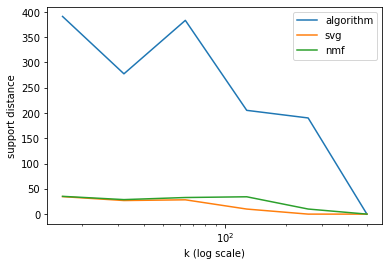

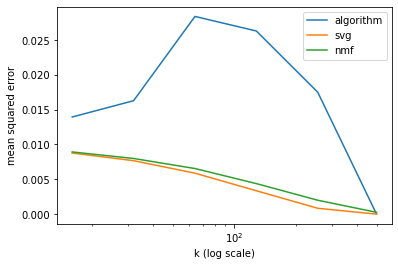

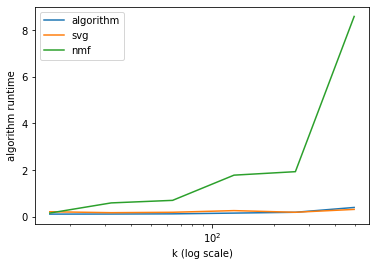

In [24]:
density = 0.01
shape = (500, 500)
demo_wrapper(shape, density)

184 of 500

k=16:
k=16 finished in 0.4716 seconds

k=32:
k=32 finished in 0.53142 seconds

k=64:
k=64 finished in 1.17482 seconds

k=128:
k=128 finished in 0.86609 seconds

k=184:
k=184 finished in 1.048 seconds


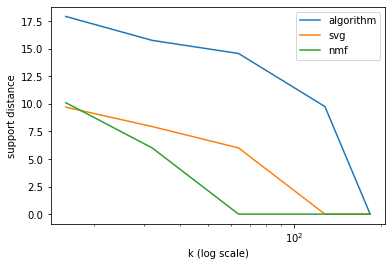

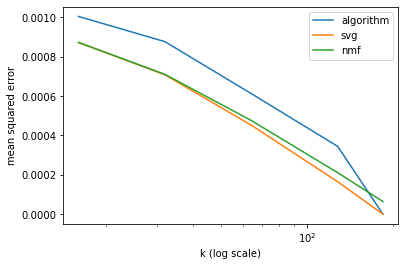

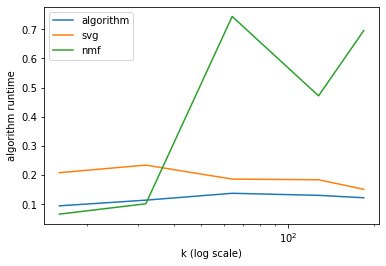

In [25]:
density = 0.001
shape = (500, 500)
demo_wrapper(shape, density)